In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import copy

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Preprocess

In [3]:
directory = './csvFiles'

In [4]:
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

In [5]:
# 파일 목록을 랜덤하게 섞습니다.
random.seed(42)  # 재현 가능한 결과를 위해 시드 설정
random.shuffle(csv_files)

In [6]:
# 첫 번째 파일에서 컬럼 이름을 가져옵니다.
first_file_path = os.path.join(directory, csv_files[0])
first_df = pd.read_csv(first_file_path)

In [7]:
separator_token = 999
separator = pd.DataFrame({col: separator_token for col in first_df.columns}, index=[0])

In [8]:
df_list = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    df = df.iloc[300:-100]
    df_list.append(df)
    df_list.append(separator) 

In [9]:
combined_df = pd.concat(df_list, ignore_index=True)

In [10]:
combined_df

,Frame,Time,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,...,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ,Unnamed: 128
0,301,3.454812,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.262754,352.2222,350.739100,0.733168,0.943708,0.631755,0.200809,359.55840,0.846429,NaN
1,302,3.465498,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.274371,352.2729,350.772300,0.733238,0.943977,0.631620,0.114945,359.53570,0.884086,NaN
2,303,3.476308,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.273871,352.2918,350.806000,0.733297,0.944234,0.631682,0.151095,359.52710,0.923961,NaN
3,304,3.487449,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.267890,352.2754,350.814000,0.733297,0.944235,0.631826,0.239347,359.53850,0.959352,NaN
4,305,3.498579,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.257694,352.2285,350.846900,0.733279,0.944438,0.631913,0.385812,359.57180,0.958712,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,4600,51.260610,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.131550,198.3722,3.791916,-1.323386,1.040075,0.924556,47.211770,37.32508,178.617100,NaN
1250496,4601,51.271360,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.133720,198.4202,3.836214,-1.323311,1.040272,0.924719,47.288450,37.23001,178.460700,NaN
1250497,4602,51.283000,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.135700,198.4699,3.866319,-1.323236,1.040406,0.924903,47.363370,37.13769,178.286900,NaN
1250498,4603,51.293670,-0.674747,0.459201,0.823021,18.44855,179.665600,357.4926,-0.614688,0.391303,...,11.140010,198.5145,3.896140,-1.322936,1.038698,0.926400,47.438840,37.06465,178.126200,NaN


In [11]:
len(combined_df)

1250500

In [12]:
# Rotation 컬럼만 선택
rotation_columns = [col for col in combined_df.columns if 'Rot' in col]

# Position 컬럼만 선택
position_columns = [col for col in combined_df.columns if 'Pos' in col]

# DataFrame 분리
rotation_df = combined_df[rotation_columns]
position_df = combined_df[position_columns]

# Rotation 컬럼만 -180~180 사이로 정규화
normalize_angle = lambda x:x if x == 999 else (x - 360) if x > 180 else (x + 360) if x < -180 else x
rotation_df = rotation_df.apply(lambda col: col.apply(normalize_angle))

# Position 컬럼만 0~1 사이로 정규화
def normalize_columns(df):
    for col in df.columns:
        if 'Pos' in col:  # 위치에 대한 컬럼만 정규화
            # 999 값을 제외하고 min 및 max를 계산
            filtered_df = df[df[col] != 999]
            min_val = filtered_df[col].min()
            max_val = filtered_df[col].max()

            # 999가 아닌 값만 정규화
            df.loc[df[col] != 999, col] = (df[col] - min_val) / (max_val - min_val)
    return df

position_df = normalize_columns(position_df)

C:\Users\admin\AppData\Local\Temp\ipykernel_32236\239680038.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 999, col] = (df[col] - min_val) / (max_val - min_val)


In [13]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = rotation_df.apply(lambda col: col.apply(lambda x: x != 999 and (x > 180 or x < -180))).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

범위를 벗어나는 값이 없습니다.


In [14]:
# 조인트 이름 추출
joint_names = [col.split('PosX')[0] for col in position_df.columns if 'PosX' in col]

# 빈 데이터 프레임 생성
posrot_df = pd.DataFrame()

# 각 조인트에 대해 위치 데이터와 회전 데이터를 순차적으로 배열
for joint in joint_names:
    posrot_df[f'{joint}PosX'] = position_df[f'{joint}PosX']
    posrot_df[f'{joint}PosY'] = position_df[f'{joint}PosY']
    posrot_df[f'{joint}PosZ'] = position_df[f'{joint}PosZ']
    posrot_df[f'{joint}RotX'] = rotation_df[f'{joint}RotX']
    posrot_df[f'{joint}RotY'] = rotation_df[f'{joint}RotY']
    posrot_df[f'{joint}RotZ'] = rotation_df[f'{joint}RotZ']

C:\Users\admin\AppData\Local\Temp\ipykernel_32236\3915166593.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  posrot_df[f'{joint}RotY'] = rotation_df[f'{joint}RotY']
C:\Users\admin\AppData\Local\Temp\ipykernel_32236\3915166593.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  posrot_df[f'{joint}RotZ'] = rotation_df[f'{joint}RotZ']
C:\Users\admin\AppData\Local\Temp\ipykernel_32236\3915166593.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [15]:
# Position 컬럼은 그대로 두고, 다시 합치기
posrot_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425514,8.262754,-7.7778,-9.260900,0.754464,0.705660,0.437026,0.200809,-0.44160,0.846429
1,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425524,8.274371,-7.7271,-9.227700,0.754483,0.705789,0.437009,0.114945,-0.46430,0.884086
2,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425540,8.273871,-7.7082,-9.194000,0.754499,0.705913,0.437017,0.151095,-0.47290,0.923961
3,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425547,8.267890,-7.7246,-9.186000,0.754499,0.705914,0.437034,0.239347,-0.46150,0.959352
4,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425527,8.257694,-7.7715,-9.153100,0.754494,0.706012,0.437045,0.385812,-0.42820,0.958712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.131550,-161.6278,3.791916,0.200521,0.752044,0.473122,47.211770,37.32508,178.617100
1250496,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.133720,-161.5798,3.836214,0.200541,0.752139,0.473142,47.288450,37.23001,178.460700
1250497,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.135700,-161.5301,3.866319,0.200561,0.752204,0.473165,47.363370,37.13769,178.286900
1250498,0.372510,0.563243,0.446288,18.44855,179.665600,-2.5074,0.383066,0.563565,0.453621,-0.7340,...,0.455199,11.140010,-161.4855,3.896140,0.200642,0.751381,0.473349,47.438840,37.06465,178.126200


In [16]:
# posrot_df.to_csv('./posrot_df.csv', index=False)

# Transformer Learning

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [18]:
# 변환된 데이터를 DataFrame으로 변환
posrot_df = pd.DataFrame(posrot_df, columns=posrot_df.columns)

In [19]:
# posrot_df = posrot_df.map(lambda x: float(f"{x:.2f}") if isinstance(x, (int, float)) else x)

In [20]:
posrot_df

,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,m_avg_L_HipPosZ,m_avg_L_HipRotX,...,m_avg_R_ElbowPosZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425514,8.262754,-7.7778,-9.260900,0.754464,0.705660,0.437026,0.200809,-0.44160,0.846429
1,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425524,8.274371,-7.7271,-9.227700,0.754483,0.705789,0.437009,0.114945,-0.46430,0.884086
2,0.586219,0.625759,0.428094,-1.17500,0.679502,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425540,8.273871,-7.7082,-9.194000,0.754499,0.705913,0.437017,0.151095,-0.47290,0.923961
3,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425547,8.267890,-7.7246,-9.186000,0.754499,0.705914,0.437034,0.239347,-0.46150,0.959352
4,0.586219,0.625759,0.428094,-1.17500,0.679492,-0.1588,0.563147,0.614554,0.427315,-0.2778,...,0.425527,8.257694,-7.7715,-9.153100,0.754494,0.706012,0.437045,0.385812,-0.42820,0.958712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250495,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.131550,-161.6278,3.791916,0.200521,0.752044,0.473122,47.211770,37.32508,178.617100
1250496,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.133720,-161.5798,3.836214,0.200541,0.752139,0.473142,47.288450,37.23001,178.460700
1250497,0.372546,0.563683,0.446105,18.35563,179.608500,-2.3751,0.383035,0.563848,0.453434,-0.4831,...,0.455031,11.135700,-161.5301,3.866319,0.200561,0.752204,0.473165,47.363370,37.13769,178.286900
1250498,0.372510,0.563243,0.446288,18.44855,179.665600,-2.5074,0.383066,0.563565,0.453621,-0.7340,...,0.455199,11.140010,-161.4855,3.896140,0.200642,0.751381,0.473349,47.438840,37.06465,178.126200


In [21]:
train = posrot_df.iloc[:1000400]
test = posrot_df.iloc[1000400:]

In [22]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=42, shuffle=False)

In [23]:
batch_size = 128
n_input = 30 # 시퀀스 수

In [24]:
class TimeseriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length] # : 입력 시퀀스 (30개의 데이터)
        y = self.data[index+self.sequence_length-1] # : 예측 시퀀스 (1개의 데이터)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

# 데이터셋과 데이터 로더를 생성
train_dataset = TimeseriesDataset(X_train.values, n_input)
val_dataset = TimeseriesDataset(X_val.values, n_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [25]:
# 데이터 로더에서 첫 번째 배치를 가져와서 형태를 확인
first_batch = next(iter(train_loader))
X, y = first_batch

print("X batch shape:", X.shape)
print("y batch shape:", y.shape)

X batch shape: torch.Size([128, 30, 126])
y batch shape: torch.Size([128, 126])


# GCN skeleton joint learning

In [26]:
joint_names = ['Pelvis', 'L_Hip', 'L_Knee', 'L_Ankle', 'L_Foot', 
                'R_Hip', 'R_Knee', 'R_Ankle', 'R_Foot', 'Spine1', 'Spine2',
               'L_Collar', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'Neck', 'Head',
               'R_Collar', 'R_Shoulder', 'R_Elbow', 'R_Wrist']
               

In [27]:
connections = [
    ('Pelvis', 'L_Hip'), ('Pelvis', 'R_Hip'),
    ('L_Hip', 'L_Knee'), ('R_Hip', 'R_Knee'),
    ('L_Knee', 'L_Ankle'), ('R_Knee', 'R_Ankle'),
    ('L_Ankle', 'L_Foot'), ('R_Ankle', 'R_Foot'),
    ('Spine1', 'Spine2'), ('Spine2', 'Pelvis'),
    ('Spine1', 'Neck'), ('Neck', 'Head'),
    ('Spine1', 'L_Collar'), ('Spine1', 'R_Collar'),
    ('L_Collar', 'L_Shoulder'), ('R_Collar', 'R_Shoulder'),
    ('L_Shoulder', 'L_Elbow'), ('R_Shoulder', 'R_Elbow'),
    ('L_Elbow', 'L_Wrist'), ('R_Elbow', 'R_Wrist')
]

In [28]:
# 조인트 이름을 인덱스로 매핑
joint_to_index = {joint: idx for idx, joint in enumerate(joint_names)}

# 연결 정보를 인덱스 쌍으로 변환
edge_pairs = [(joint_to_index[joint_from], joint_to_index[joint_to]) for joint_from, joint_to in connections]

# edge_index 생성
edge_index = torch.tensor(edge_pairs, dtype=torch.long).t().contiguous()

In [29]:
edge_index

tensor([[ 0,  0,  1,  5,  2,  6,  3,  7,  9, 10,  9, 15,  9,  9, 11, 17, 12, 18,
         13, 19],
        [ 1,  5,  2,  6,  3,  7,  4,  8, 10,  0, 15, 16, 11, 17, 12, 18, 13, 19,
         14, 20]])

In [30]:
# 사용 가능한 GPU 목록을 출력
available_gpus = torch.cuda.device_count()
print("Available GPUs:", available_gpus)

# 현재 장치를 출력 (GPU 사용 가능시 CUDA 장치, 그렇지 않으면 CPU)
current_device = torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'
print("Current device:", torch.cuda.get_device_name(current_device) if torch.cuda.is_available() else current_device)

Available GPUs: 1
Current device: NVIDIA GeForce RTX 4090


In [31]:
# 하이퍼파라미터 설정
batch_size = 128
num_nodes = 21  # 노드 수 (신체 관절 수)
num_node_features = 6  # 각 노드의 특성 수 (위치 및 회전 정보)
num_classes = 126  # 출력 클래스 수 (전체 특성 수)
sequence_length = 30  # 시퀀스 길이
in_channels = 30
out_channels = 256

lr = 0.0001
patience = 10
min_delta = 0.001
epochs = 50

In [32]:
# class TemporalLayer(nn.Module):
#     """ 시간적 특성을 처리하기 위한 레이어 """
#     def __init__(self, in_channels, out_channels):
#         super(TemporalLayer, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)

#     def forward(self, x):
#         print("Input shape to TemporalLayer:", x.shape)  # TemporalLayer 입력 형태 확인
#         x = x.permute(0, 2, 1)  # [batch_size, in_channels, sequence_length]
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         return x

# class GCNWithTemporal(nn.Module):
#     """ 공간적 및 시간적 특성을 모두 고려하는 GCN 모델 """
#     def __init__(self, num_node_features, num_classes, sequence_length):
#         super(GCNWithTemporal, self).__init__()
#         self.conv1 = GCNConv(num_node_features, 64)
#         self.conv2 = GCNConv(64, 128)
#         self.conv3 = GCNConv(128, 256)
#         self.temporal_layer = TemporalLayer(sequence_length, 256)
#         self.out = nn.Linear(num_nodes * 256 * sequence_length, num_classes)

#     def forward(self, x, edge_index):
#         # 입력 데이터의 형태 확인
#         print("Original input shape to GCNWithTemporal:", x.shape)
        
#         # x의 형태를 [batch_size, sequence_length, num_nodes * num_node_features]로 변환
#         batch_size, sequence_length, num_nodes, num_node_features = x.shape
#         x = x.reshape(batch_size * sequence_length, num_nodes, num_node_features)

#         # 입력 데이터의 총 요소 수 확인
#         input_elements = batch_size * sequence_length * num_nodes * num_node_features
#         print("Total elements in input:", input_elements)

#         # 새로운 형태로 변환 전에 요소 수 일치 확인
#         assert input_elements == x.numel(), "Mismatch in total elements when reshaping"

#         # 새로운 형태로 변환
#         x = x.reshape(batch_size * sequence_length, num_nodes * num_node_features)        
        
#         # GCN 적용
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = F.relu(self.conv2(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = F.relu(self.conv3(x, edge_index))
        
#         # 원래 형태로 복원
#         x = x.view(batch_size, sequence_length, -1)
        
#         # 시간 차원을 처리합니다.
#         x = self.temporal_layer(x)
#         print("Shape after TemporalLayer in GCNWithTemporal:", x.shape)  # TemporalLayer 처리 후 형태 확인

#         # 최종 출력 차원을 확인
#         x = x.reshape(x.size(0), -1)  # [batch_size, sequence_length * num_nodes * out_channels]
#         print("Shape before final linear layer in GCNWithTemporal:", x.shape)  # 최종 선형 레이어 전 형태 확인

#         x = self.out(x)
#         return x

In [39]:
class TemporalLayer(nn.Module):
    """ 시간적 특성을 처리하기 위한 레이어 """
    def __init__(self, in_channels, out_channels):
        super(TemporalLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        print("TemporalLayer Initialized:")
        print(self)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes * num_node_features, sequence_length]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class GCNWithTemporal(nn.Module):
    """ 공간적 및 시간적 특성을 모두 고려하는 GCN 모델 """
    def __init__(self, num_node_features, num_classes, sequence_length, num_nodes):
        super(GCNWithTemporal, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.temporal_layer = TemporalLayer(num_nodes * 256, 256)
        self.out = nn.Linear(7680, num_classes) # [batch_size, 256 * 30] = [batch_size, 7680]
        print("GCNWithTemporal Initialized:")
        print(self)

    def forward(self, x, edge_index):
        # 입력 데이터의 형태 확인 (4차원으로 처리)
        # print("Original input shape to GCNWithTemporal:", x.shape) [128, 30, 21, 6])
        
        # x의 형태를 [batch_size, sequence_length, num_nodes, num_node_features]에서
        # [batch_size * sequence_length, num_nodes, num_node_features]로 변환
        batch_size, sequence_length, num_nodes, num_node_features = x.shape
        x = x.reshape(batch_size * sequence_length, num_nodes, num_node_features)

        # GCN 적용
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        # print("Shape after GCN layers in GCNWithTemporal:", x.shape) [3840, 21, 256])

        # 원래 형태로 복원 (배치 사이즈와 시퀀스 길이를 유지하며 차원 재구성)
        x = x.view(batch_size, sequence_length, -1)
        # print("Shape before TemporalLayer in GCNWithTemporal:", x.shape) [128, 30, 5376])
       
        # 시간 차원을 처리합니다.
        x = self.temporal_layer(x)
        # print("Shape after TemporalLayer in GCNWithTemporal:", x.shape) [128, 256, 30])

        # 최종 출력 차원을 확인
        x = x.reshape(x.size(0), -1)
        # print("Shape before final linear layer in GCNWithTemporal:", x.shape) [128, 7680])

        x = self.out(x)
        return x


In [40]:
# 모델, 손실 함수, 최적화 알고리즘 초기화
gcn_model = GCNWithTemporal(num_node_features, num_classes, sequence_length, num_nodes)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.0001)
loss_function = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

TemporalLayer Initialized:
TemporalLayer(
  (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
)
GCNWithTemporal Initialized:
GCNWithTemporal(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (temporal_layer): TemporalLayer(
    (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Linear(in_features=7680, out_features=126, bias=True)
)


In [41]:
# 모델을 현재 장치로 이동합니다.
gcn_model.to(current_device)

GCNWithTemporal(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (temporal_layer): TemporalLayer(
    (conv1): Conv1d(5376, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Linear(in_features=7680, out_features=126, bias=True)
)

In [42]:
# 손실을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 가장 좋은 손실 값 초기화
best_loss = float('inf')
early_stopping_counter = 0


In [43]:
# 학습 루프 함수
def train_loop(gcn_model, dataloader, optimizer, loss_function, device, edge_index, num_nodes, num_node_features, sequence_length):
    gcn_model.train()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for data, target in progress_bar:
        # 데이터 형태와 edge_index 검증을 위한 출력
        # print("Original data shape:", data.shape)
        # print("Edge index shape:", edge_index.shape)
        # print("Edge index:", edge_index)

        # 데이터 차원 변경
        edge_index = edge_index.to(device)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, num_nodes, num_node_features, sequence_length)  # 여기에 추가
        # print("View applied data shape:", data.shape)
        data = data.permute(0, 3, 1, 2)  # 여기에 추가
        # print("Permute applied data shape:", data.shape)
        target = target.view(-1, num_classes)

        # 데이터 형태 출력
        # print("Transformed data shape:", data.shape)
        
        optimizer.zero_grad()
        output = gcn_model(data, edge_index)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# 검증 루프 함수
def val_loop(gcn_model, dataloader, loss_function, device, edge_index, num_nodes, num_node_features, sequence_length):
    gcn_model.eval()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for data, target in progress_bar:
            edge_index = edge_index.to(device)
            data, target = data.to(device), target.to(device)
            data = data.view(-1, num_nodes, num_node_features, sequence_length)  # 여기에 추가
            data = data.permute(0, 3, 1, 2)  # 여기에 추가
            target = target.view(-1, num_classes)

            output = gcn_model(data, edge_index)
            loss = loss_function(output, target)

            total_loss += loss.item() * data.size(0)
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss

In [44]:
# Early Stopping 준비
best_loss = float('inf')
early_stopping_counter = 0

# 메인 학습 루프
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    # train_loop 함수 호출 시 sequence_length 추가
    avg_train_loss = train_loop(gcn_model, train_loader, optimizer, loss_function, current_device, edge_index, num_nodes, num_node_features, sequence_length)
    # val_loop 함수 호출 시 sequence_length 추가
    avg_val_loss = val_loop(gcn_model, val_loader, loss_function, current_device, edge_index, num_nodes, num_node_features, sequence_length)

    print(f'Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(gcn_model.state_dict())
        torch.save(gcn_model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# 최적 모델 가중치 로드
gcn_model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/50


Training Loss: 711.9244928677884, Validation Loss: 788.8517367573222
Epoch 2/50


Training Loss: 358.7118828827024, Validation Loss: 560.3730074691549
Epoch 3/50


Training Loss: 284.41586507318823, Validation Loss: 493.36240486550685
Epoch 4/50


Training Loss: 247.9497602418751, Validation Loss: 488.89757155656997
Epoch 5/50


Training Loss: 223.95273410737425, Validation Loss: 471.78337392617226
Epoch 6/50


Training Loss: 207.6366826467614, Validation Loss: 441.4532932815206
Epoch 7/50


Training Loss: 194.65514333498348, Validation Loss: 458.93165860823774
Epoch 8/50


Training Loss: 185.41997616593588, Validation Loss: 436.8026108560823
Epoch 9/50


Training Loss: 177.42411340910633, Validation Loss: 439.8713241682331
Epoch 10/50


Training Loss: 170.01063335463618, Validation Loss: 470.71602048026824
Epoch 11/50


Training Loss: 164.92958290219846, Validation Loss: 412.36857120507756
Epoch 12/50


Training Loss: 160.12470935548544, Validation Loss: 425.2737136838456
Epoch 13/50


Training Loss: 155.07263824065888, Validation Loss: 372.98216339507496
Epoch 14/50


Training Loss: 151.25527531354183, Validation Loss: 405.8693326570255
Epoch 15/50


Training Loss: 148.20602577254175, Validation Loss: 424.4395577617087
Epoch 16/50


Training Loss: 144.52426730729607, Validation Loss: 400.9511461082551
Epoch 17/50


Training Loss: 141.37915951240615, Validation Loss: 398.69595946087946
Epoch 18/50


Training Loss: 139.20276754430827, Validation Loss: 387.86861488412495
Epoch 19/50


Training Loss: 136.24398738724506, Validation Loss: 418.6555034609363
Epoch 20/50


Training Loss: 133.56539861359806, Validation Loss: 362.51707048833407
Epoch 21/50


Training Loss: 129.00150970478927, Validation Loss: 350.5799358642184
Epoch 22/50


Training Loss: 127.03575357007071, Validation Loss: 348.2734961447136
Epoch 23/50


Training Loss: 125.67638763945696, Validation Loss: 354.13868368412244
Epoch 24/50


Training Loss: 124.5984539591009, Validation Loss: 361.18145520688853
Epoch 25/50


Training Loss: 123.78965685575591, Validation Loss: 357.86384202619155
Epoch 26/50


Training Loss: 122.85058636954804, Validation Loss: 362.4070121140105
Epoch 27/50


Training Loss: 122.19554187827173, Validation Loss: 359.74953651375785
Epoch 28/50


Training Loss: 121.59978981774866, Validation Loss: 362.2458802988758
Epoch 29/50


Training Loss: 121.85515792663011, Validation Loss: 352.831356474558
Epoch 30/50


Training Loss: 121.36539105079727, Validation Loss: 353.1892886817646
Epoch 31/50


Training Loss: 121.18662284054349, Validation Loss: 352.86293311093124
Epoch 32/50


Training Loss: 120.88797777334587, Validation Loss: 353.2499092080274
Early stopping


<All keys matched successfully>

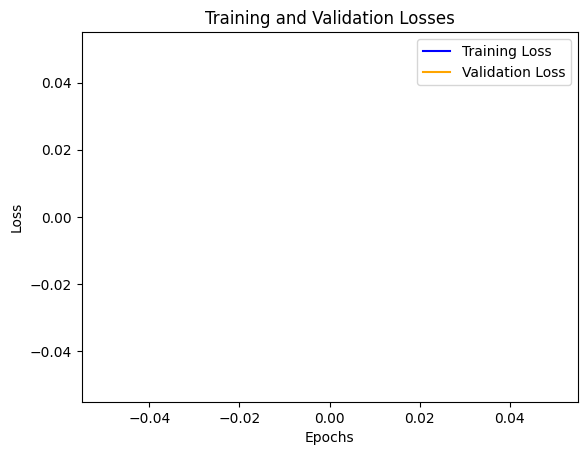

In [45]:
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Transformer Model

In [46]:
batch_size = 128
n_input = 30  # Sequence length
n_features = 126  # Number of features
output_units = (21 * 6)  # Output shape
head_size = 256  # Size of attention head
num_heads = 7  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer
num_blocks = 4  # Number of transformer blocks
mlp_units = [512, 256, 128]  # Size of the dense layers of the final classifier
dropout_rate = 0.3

In [63]:
# GCN 모델의 출력을 저장할 리스트 초기화
gcn_outputs = []

# train_loader에서 배치를 가져와서 GCN 모델의 출력을 수집
for data, _ in train_loader:
    data = data.to(current_device)
    
    # 데이터의 현재 차원을 확인
    print("Data shape:", data.shape)

    # # 데이터 차원 확인 및 변환
    # batch_size, seq_len, features = data.shape[0], sequence_length, num_node_features
    # if len(data.shape) != 4 or data.shape[2] * data.shape[3] != features * num_nodes:
    #     print(f"Incorrect data shape: {data.shape}")
    #     break

    # 데이터 차원 변환
    data = data.permute(0, 1, 3, 2)  # [batch_size, sequence_length, num_nodes, num_node_features]
    data = data.reshape(batch_size * seq_len, num_nodes*num_node_features)

    try:
        gcn_output = gcn_model(data, edge_index)
        gcn_outputs.append(gcn_output.detach())
    except RuntimeError as e:
        print(f"An error occurred: {e}")
        print(f"Data shape: {data.shape}")
        break

Data shape: torch.Size([128, 30, 126])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

In [52]:
# Positional Encoding 정의
class PositionalEncoding(nn.Module):
    def __init__(self, n_features, n_input):
        super(PositionalEncoding, self).__init__() # 상속받은 nn.Module 클래스의 __init__() 메서드 호출
        pe = torch.zeros(n_input, n_features) # 가장 큰 시퀀스 길이인 max_len을 기준으로 모두 0으로 채워진 크기가 (max_len, n_features)인 텐서 생성
        position = torch.arange(0, n_input, dtype=torch.float).unsqueeze(1) # position 텐서 생성

        # div_term을 계산하는 방식 수정
        div_term = torch.exp(torch.arange(0, n_features, 2).float() * (-math.log(10000.0) / n_features)) # div_term 계산
        
        # div_term의 길이를 n_features의 절반으로 조정
        div_term = div_term.repeat_interleave(2)[:n_features] # div_term 텐서 생성

        pe[:, 0::2] = torch.sin(position * div_term[0::2]) # 짝수 인덱스에는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term[1::2]) # 홀수 인덱스에는 cos 함수 적용
        pe = pe.unsqueeze(0) # pe = [bs, seq_len, n_feautres]
        self.register_buffer('pe', pe) # pe 텐서를 모델의 버퍼로 등록

    def forward(self, x):
        pe = self.pe[:, :x.size(1), :].to(x.device)
        # print(f"x.size(): {x.size()}, pe.size(): {pe.size()}")
        x = x + pe
        return x

# Transformer Block 정의
class TransformerBlock(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(n_features, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(n_features, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, n_features)
        )
        self.norm1 = nn.LayerNorm(n_features)
        self.norm2 = nn.LayerNorm(n_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x
    
# 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout, n_input):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(n_features, n_input)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(n_features, num_heads, ff_dim, dropout) for _ in range(num_blocks)])
        
        self.layers = nn.Sequential()
        # 첫 번째 nn.Linear 층의 입력 차원을 n_features로 설정
        self.layers.add_module("dense_0", nn.Linear(n_features, mlp_units[0]))
        self.layers.add_module("relu_0", nn.ReLU())
        self.layers.add_module("dropout_0", nn.Dropout(dropout))
        self.layers.add_module("norm_0", nn.LayerNorm(mlp_units[0]))

        # 이후 층들에 대한 설정
        for i in range(1, len(mlp_units)):
            self.layers.add_module(f"dense_{i}", nn.Linear(mlp_units[i-1], mlp_units[i]))
            self.layers.add_module(f"relu_{i}", nn.ReLU())
            self.layers.add_module(f"dropout_{i}", nn.Dropout(dropout))
            self.layers.add_module(f"norm_{i}", nn.LayerNorm(mlp_units[i]))

        # 최종 출력 층
        self.out = nn.Linear(mlp_units[-1], n_features)

    def forward(self, x):
        x = self.pos_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = torch.mean(x, dim=1)
        x = self.layers(x)
        return self.out(x)

transformer_model = TransformerModel(n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout_rate, n_input)


In [ ]:
# Positional Encoding 적용
pos_encoder = PositionalEncoding(n_features=n_features, n_input=n_input)
# transformer_input_sequences = pos_encoder(transformer_input_sequences)

In [ ]:
# pos_encoder = PositionalEncoding(n_features, n_input)
# x = torch.rand(128, 30, 126)
# y = pos_encoder(x)

In [ ]:
column_order = [
    'm_avg_PelvisPosX', 'm_avg_PelvisPosY', 'm_avg_PelvisPosZ',
    'm_avg_PelvisRotX', 'm_avg_PelvisRotY', 'm_avg_PelvisRotZ',

    'm_avg_L_HipPosX', 'm_avg_L_HipPosY', 'm_avg_L_HipPosZ',
    'm_avg_L_HipRotX', 'm_avg_L_HipRotY', 'm_avg_L_HipRotZ',

    'm_avg_L_KneePosX', 'm_avg_L_KneePosY', 'm_avg_L_KneePosZ',
    'm_avg_L_KneeRotX', 'm_avg_L_KneeRotY', 'm_avg_L_KneeRotZ',

    'm_avg_L_AnklePosX', 'm_avg_L_AnklePosY', 'm_avg_L_AnklePosZ',
    'm_avg_L_AnkleRotX', 'm_avg_L_AnkleRotY', 'm_avg_L_AnkleRotZ',

    'm_avg_L_FootPosX', 'm_avg_L_FootPosY', 'm_avg_L_FootPosZ',
    'm_avg_L_FootRotX', 'm_avg_L_FootRotY', 'm_avg_L_FootRotZ',

    'm_avg_R_HipPosX', 'm_avg_R_HipPosY', 'm_avg_R_HipPosZ',
    'm_avg_R_HipRotX', 'm_avg_R_HipRotY', 'm_avg_R_HipRotZ',

    'm_avg_R_KneePosX', 'm_avg_R_KneePosY', 'm_avg_R_KneePosZ',
    'm_avg_R_KneeRotX', 'm_avg_R_KneeRotY', 'm_avg_R_KneeRotZ',

    'm_avg_R_AnklePosX', 'm_avg_R_AnklePosY', 'm_avg_R_AnklePosZ',
    'm_avg_R_AnkleRotX', 'm_avg_R_AnkleRotY', 'm_avg_R_AnkleRotZ',

    'm_avg_R_FootPosX', 'm_avg_R_FootPosY', 'm_avg_R_FootPosZ',
    'm_avg_R_FootRotX', 'm_avg_R_FootRotY', 'm_avg_R_FootRotZ',

    'm_avg_Spine1PosX', 'm_avg_Spine1PosY', 'm_avg_Spine1PosZ',
    'm_avg_Spine1RotX', 'm_avg_Spine1RotY', 'm_avg_Spine1RotZ',

    'm_avg_Spine2PosX', 'm_avg_Spine2PosY', 'm_avg_Spine2PosZ',
    'm_avg_Spine2RotX', 'm_avg_Spine2RotY', 'm_avg_Spine2RotZ',

    'm_avg_L_CollarPosX', 'm_avg_L_CollarPosY', 'm_avg_L_CollarPosZ',
    'm_avg_L_CollarRotX', 'm_avg_L_CollarRotY', 'm_avg_L_CollarRotZ',

    'm_avg_L_ShoulderPosX', 'm_avg_L_ShoulderPosY', 'm_avg_L_ShoulderPosZ',
    'm_avg_L_ShoulderRotX', 'm_avg_L_ShoulderRotY', 'm_avg_L_ShoulderRotZ',

    'm_avg_L_ElbowPosX', 'm_avg_L_ElbowPosY', 'm_avg_L_ElbowPosZ',
    'm_avg_L_ElbowRotX', 'm_avg_L_ElbowRotY', 'm_avg_L_ElbowRotZ',

    'm_avg_L_WristPosX', 'm_avg_L_WristPosY', 'm_avg_L_WristPosZ',
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',

    'm_avg_NeckPosX', 'm_avg_NeckPosY', 'm_avg_NeckPosZ',
    'm_avg_NeckRotX', 'm_avg_NeckRotY', 'm_avg_NeckRotZ',

    'm_avg_HeadPosX', 'm_avg_HeadPosY', 'm_avg_HeadPosZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',

    'm_avg_R_CollarPosX', 'm_avg_R_CollarPosY', 'm_avg_R_CollarPosZ',
    'm_avg_R_CollarRotX', 'm_avg_R_CollarRotY', 'm_avg_R_CollarRotZ',

    'm_avg_R_ShoulderPosX', 'm_avg_R_ShoulderPosY', 'm_avg_R_ShoulderPosZ',
    'm_avg_R_ShoulderRotX', 'm_avg_R_ShoulderRotY', 'm_avg_R_ShoulderRotZ',

    'm_avg_R_ElbowPosX', 'm_avg_R_ElbowPosY', 'm_avg_R_ElbowPosZ',
    'm_avg_R_ElbowRotX', 'm_avg_R_ElbowRotY', 'm_avg_R_ElbowRotZ',
    
    'm_avg_R_WristPosX', 'm_avg_R_WristPosY', 'm_avg_R_WristPosZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ'
    ]

In [ ]:
column_names = [
    'm_avg_HeadPosX', 'm_avg_HeadPosY', 'm_avg_HeadPosZ',
    'm_avg_L_WristPosX', 'm_avg_L_WristPosY', 'm_avg_L_WristPosZ',
    'm_avg_R_WristPosX', 'm_avg_R_WristPosY', 'm_avg_R_WristPosZ',
    'm_avg_L_FootPosX', 'm_avg_L_FootPosY', 'm_avg_L_FootPosZ',
    'm_avg_R_FootPosX', 'm_avg_R_FootPosY', 'm_avg_R_FootPosZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ',
    'm_avg_L_FootRotX', 'm_avg_L_FootRotY', 'm_avg_L_FootRotZ',
    'm_avg_R_FootRotX', 'm_avg_R_FootRotY', 'm_avg_R_FootRotZ',
]

weighted_columns_indices = [column_order.index(name) for name in column_names]
print(weighted_columns_indices)

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, weighted_columns_indices, weight_for_weighted_columns, threshold, penalty_weight):
        super(CustomLoss, self).__init__()
        self.weighted_columns_indices = torch.tensor(weighted_columns_indices)
        self.weight_for_weighted_columns = weight_for_weighted_columns
        self.threshold = threshold  # 신체 움직임의 임계값
        self.penalty_weight = penalty_weight  # 비정상적 움직임에 대한 패널티 가중치

    def forward(self, y_true, y_pred):
        # 각 조인트의 6개 특성에 대한 손실을 계산하기 위해 y_true와 y_pred의 마지막 차원을 제거
        y_pred_values = y_pred[:, :]

        # MSE 계산
        mse = F.mse_loss(y_true[:, :], y_pred_values, reduction='none')
        mse = mse.mean(axis=-1)

        # 특정 joint에 대한 가중치 적용
        weighted_mse = y_pred[:, self.weighted_columns_indices]
        weighted_mse = (weighted_mse ** 2) * self.weight_for_weighted_columns
        mse += weighted_mse.mean(axis=-1)

        # 과도한 움직임에 대한 패널티 적용
        excessive_movement_penalty = (y_pred - y_true).abs() > self.threshold
        penalty = excessive_movement_penalty.type(torch.float32) * self.penalty_weight
        mse += penalty.mean(axis=-1)

        return mse.mean()  # 전체 배치에 대한 평균 손실 반환

# 가중치를 적용할 열 인덱스와 가중치 값
weighted_columns_indices = weighted_columns_indices
weight_for_weighted_columns = 2.0

# 임계값과 패널티 가중치 설정
threshold = 10.0  # 예시 임계값
penalty_weight = 0.8  # 예시 패널티 가중치

# CustomLoss 인스턴스 생성
custom_loss_instance = CustomLoss(
    weighted_columns_indices=weighted_columns_indices,
    weight_for_weighted_columns=weight_for_weighted_columns,
    threshold=threshold,
    penalty_weight=penalty_weight
)

In [ ]:
# 최적화기와 손실 함수
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001)
criterion = custom_loss_instance

In [ ]:
# 설정
epochs = 100
patience = 7  # Early Stopping patience
best_loss = np.inf
early_stopping_counter = 0

In [ ]:
# Learning Rate Scheduler 설정
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

In [ ]:
# 사용 가능한 GPU 목록을 출력
available_gpus = torch.cuda.device_count()
print("Available GPUs:", available_gpus)

# 현재 장치를 출력 (GPU 사용 가능시 CUDA 장치, 그렇지 않으면 CPU)
current_device = torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'
print("Current device:", torch.cuda.get_device_name(current_device) if torch.cuda.is_available() else current_device)

In [ ]:
model = transformer_model.to(current_device)

In [ ]:
summary(model, input_size=(n_input, n_features))

In [ ]:
# 훈련 루프
train_losses = []
val_losses = []

# 가장 좋은 손실 값 초기화
best_loss = float('inf')
early_stopping_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    # 훈련 데이터 로더에 대한 프로그레스 바 추가
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    for data, target in train_progress_bar:
        # 데이터를 현재 장치로 이동
        data = data.to(current_device)
        target = target.to(current_device)
        edge_index = edge_index.to(current_device)  # edge_index도 같은 장치로 이동

        # GCN 모델에 데이터와 edge_index를 전달하고 출력을 얻음
        gcn_output = gcn_model(data, edge_index)

        # Transformer 모델에 GCN 모델의 출력을 전달
        output = transformer_model(gcn_output)  # transformer_model로 이름을 명확히 표시

        # 손실 계산
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 프로그레스 바 업데이트
        train_progress_bar.set_postfix({'train_loss': loss.item()})

    # 에포크당 평균 훈련 손실 저장
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    # 검증 데이터 로더에 대한 프로그레스 바 추가
    val_progress_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch')

    with torch.no_grad():
        for data, target in val_progress_bar:
            # 데이터를 현재 장치로 이동
            data = data.to(current_device)
            target = target.to(current_device)
            edge_index = edge_index.to(current_device)

            # GCN 모델에 데이터를 전달하고 출력을 얻음
            gcn_output = gcn_model(data, edge_index)

            # Transformer 모델에 GCN 모델의 출력을 전달
            output = transformer_model(gcn_output)

            # 손실 계산
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)

            # 프로그레스 바 업데이트
            val_progress_bar.set_postfix({'val_loss': loss.item()})

    # 에포크당 평균 검증 손실 저장
    val_losses.append(val_loss / len(val_loader.dataset))

    # 로그 출력
    print(f'Epoch {epoch+1} \t Training Loss: {train_loss / len(train_loader.dataset)} \t Validation Loss: {val_loss / len(val_loader.dataset)}')

    # Learning Rate Scheduler 업데이트
    scheduler.step(val_loss)

    # Early Stopping 체크
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        # 모델 상태 저장 (필요에 따라 GCN 모델의 상태도 저장)
        torch.save({'transformer_model': model.state_dict(),
                    'gcn_model': gcn_model.state_dict()}, 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# 가장 좋은 모델 가중치 로드
model.load_state_dict(best_model_wts)

In [ ]:
torch.save(model.state_dict(), 'final_model_Transformer.pth')

In [ ]:
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test with Real Data

In [ ]:
test_df = pd.read_csv('./B01_TransformData_FinalAvatar_20230922_171230.csv').iloc[300:-100]

In [ ]:
test_df.head()

In [ ]:
test_rotation_columns = [col for col in test_df.columns if 'Rot' in col]

test_position_columns = [col for col in test_df.columns if 'Pos' in col]

# DataFrame 분리
test_rotation_df = test_df[test_rotation_columns]
test_position_df = test_df[test_position_columns]

# Rotation 컬럼만 -180~180 사이로 정규화
normalize_angle = lambda x:x if x == 999 else (x - 360) if x > 180 else (x + 360) if x < -180 else x
test_rotation_df = test_rotation_df.apply(lambda col: col.apply(normalize_angle))

# Position 컬럼만 0~1 사이로 정규화
def normalize_columns(df):
    for col in df.columns:
        if 'Pos' in col:  # 위치에 대한 컬럼만 정규화
            min_val = df[col].min()
            max_val = df[col].max()
            df[col] = (df[col] - min_val) / (max_val - min_val)
    return df

test_position_df = normalize_columns(test_position_df)

In [ ]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = test_rotation_df.apply(lambda col: col.apply(lambda x: x != 999 and (x > 180 or x < -180))).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

In [ ]:
# Position 컬럼은 그대로 두고, 다시 합치기
# test_posrot_df = pd.concat([test_position_df, test_rotation_df], axis=1)

In [ ]:
# 조인트 이름 추출
joint_names = [col.split('PosX')[0] for col in test_position_df.columns if 'PosX' in col]

# 빈 데이터 프레임 생성
test_posrot_df = pd.DataFrame()

# 각 조인트에 대해 위치 데이터와 회전 데이터를 순차적으로 배열
for joint in joint_names:
    test_posrot_df[f'{joint}PosX'] = test_position_df[f'{joint}PosX']
    test_posrot_df[f'{joint}PosY'] = test_position_df[f'{joint}PosY']
    test_posrot_df[f'{joint}PosZ'] = test_position_df[f'{joint}PosZ']
    test_posrot_df[f'{joint}RotX'] = test_rotation_df[f'{joint}RotX']
    test_posrot_df[f'{joint}RotY'] = test_rotation_df[f'{joint}RotY']
    test_posrot_df[f'{joint}RotZ'] = test_rotation_df[f'{joint}RotZ']

In [ ]:
test_posrot_df

In [ ]:
# test_posrot_df = test_posrot_df.map(lambda x: float(f"{x:.2f}") if isinstance(x, (int, float)) else x)

In [ ]:
# 결과를 새로운 CSV 파일로 저장합니다.
test_posrot_df.to_csv('./test_posrot_df.csv', index=True)

In [ ]:
# 모델 불러오기
model = TransformerModel(
    n_features=n_features,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_blocks=num_blocks,
    mlp_units=mlp_units,
    dropout=dropout_rate,
    n_input=n_input
)

model.load_state_dict(torch.load('final_model_Transformer.pth'))

# 모델을 평가 모드로 설정
model.eval()

# 예측 값을 넣을 빈 리스트
test_predictions = []

# 훈련 데이터셋에서 마지막 입력 개수의 값을 가져온 후
current_batch = torch.from_numpy(test_posrot_df[-n_input:].values.astype(np.float32)).reshape((1, n_input, n_features))

# 모델이 사용하는 디바이스를 확인하고 데이터를 해당 디바이스로 옮깁니다.
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(current_device)
current_batch = current_batch.to(current_device)

# 예측 과정 반복
with torch.no_grad():  # 그래디언트 계산을 비활성화
    for i in range(1):
        # 현재 배치에서 다음 포인트를 예측
        current_pred = model(current_batch).cpu().numpy()[0]  # 마지막 시퀀스 포인트 예측

        # 예측된 마지막 프레임을 리스트에 추가
        test_predictions.append(current_pred)

        # 새로운 배치 생성: 마지막 시퀀스 제외하고 예측값 추가
        current_batch = np.roll(current_batch.cpu().numpy(), -1, axis=1)
        current_batch[:, -1, :] = current_pred
        current_batch = torch.from_numpy(current_batch).to(current_device)

In [ ]:
test_predictions_array = np.array(test_predictions)

In [ ]:
# 변환된 배열을 데이터프레임으로 변환합니다. 이때 column_order 리스트를 열 이름으로 사용합니다.
test_predictions = pd.DataFrame(test_predictions_array, columns=column_order)

# test_predictions 데이터프레임을 CSV 파일로 저장합니다.
test_predictions.to_csv('./test_predictions.csv', index=True)


In [ ]:
test_predictions

In [ ]:
# input 데이터(test_df)의 마지막 30 프레임과 
last_inputs_df = test_posrot_df.iloc[-30:][column_order].reset_index(drop=True)
test_predictions_df = pd.DataFrame(test_predictions_array, columns=column_order)

test_combined_df = pd.concat([last_inputs_df, test_predictions_df], ignore_index=True)

In [ ]:
test_combined_df

In [ ]:
test_combined_df.to_csv('./test_combined_df.csv', index=True)

# Visualize

In [ ]:
import matplotlib
matplotlib.use('TkAgg')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

In [ ]:
def visualize_skeleton(df, connections):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each joint
    for joint in joint_names:
        ax.scatter(df[f'{joint}PosX'], df[f'{joint}PosY'], df[f'{joint}PosZ'], label=joint)

    # Draw lines (bones) connecting the joints
    for connection in connections:
        joint_from, joint_to = connection
        # Update to use the correct column names
        ax.plot(
            [df[f'm_avg_{joint_from}PosX'], df[f'm_avg_{joint_to}PosX']],
            [df[f'm_avg_{joint_from}PosY'], df[f'm_avg_{joint_to}PosY']],
            [df[f'm_avg_{joint_from}PosZ'], df[f'm_avg_{joint_to}PosZ']],
            'k-'
        )

    # Set labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='best')

    # Set the initial viewing angle
    ax.view_init(elev=20., azim=-90)

    plt.show()


In [ ]:
visualize_skeleton(test_predictions.iloc[0], connections)
